#MIT 6.036 Fall 2020: Homework 7#

This colab notebook provides code and a framework for problem 2-4 of the homework.  You can work out your solutions here, then submit your results back on the homework page when ready.

**Note**: You can go to `File > Save a copy in Drive...` to save your own copy of this notebook for editing.

## <section>**Setup**</section>

First, download the code distribution for this homework that contains test cases and helper functions.

Run the next code block to download and import the code for this lab.


In [ ]:
!rm -rf code_for_hw7*
!rm -rf mnist
!rm -rf data
!wget --no-check-certificate --quiet https://go.odl.mit.edu/subject/6.036/_static/catsoop/homework/hw07/code_for_hw7.zip
!unzip code_for_hw7.zip
!mv code_for_hw7/* .

from code_for_hw7 import *
import numpy as np
import modules_disp as disp


Archive:  code_for_hw7.zip
   creating: code_for_hw7/
  inflating: code_for_hw7/code_for_hw7.py  
  inflating: code_for_hw7/pytorch_code_for_hw7.py  
  inflating: code_for_hw7/code_for_hw7_pytorch.py  
   creating: code_for_hw7/data/
  inflating: code_for_hw7/data/data5_validate.csv  
  inflating: code_for_hw7/data/data5_train.csv  
  inflating: code_for_hw7/data/data1_train.csv  
  inflating: code_for_hw7/data/data1_validate.csv  
  inflating: code_for_hw7/data/data2_train.csv  
  inflating: code_for_hw7/data/data2_validate.csv  
  inflating: code_for_hw7/data/data3_train.csv  
  inflating: code_for_hw7/data/data3_validate.csv  
  inflating: code_for_hw7/data/data3class_train.csv  
  inflating: code_for_hw7/data/data4_train.csv  
  inflating: code_for_hw7/data/data4_validate.csv  
  inflating: code_for_hw7/data/dataXor_train.csv  
  inflating: code_for_hw7/expected_results.py  
  inflating: code_for_hw7/modules_disp.py  
  inflating: code_for_hw7/utils_hw7.py  
   creating: code_for_h

# 2) Implementing Neural Networks

This homework considers neural networks with multiple layers. Each layer has multiple inputs and outputs, and can be broken down into two parts:

<br>

A linear module that implements a linear transformation:     $ z_j = (\sum^{m}_{i=1} x_i W_{i,j}) + {W_0}_jz$

specified by a weight matrix $W$ and a bias vector $W_0$. The input is $[x_1, \ldots, x_m]^T$. The output is $[z_1, \ldots, z_n]^T$

<br>

An activation module that applies an activation function to the outputs of the linear module for some activation function $f$, such as Tanh or ReLU in the hidden layers or Softmax (see below) at the output layer. We write the output as: $[f(z_1), \ldots, f(z_m)]^T$, although technically, for some activation functions such as softmax, each output will depend on all the $z_i$.

Although for "real" applications you want to use one of the many packaged implementations of neural networks (we'll start using one of those soon), there is no substitute for implementing one yourself to get an in-depth understanding. Luckily, that is relatively easy to do if we're not too concerned with maximum efficiency.

We'll use the modular implementation that we guided you through in the previous problem, which leads to clean code. The basic framework for SGD training is given below. We can construct a network and train it as follows:

```
# build a 3-layer network
net = Sequential([Linear(2,3), Tanh(),
                  Linear(3,3), Tanh(),
    	          Linear(3,2), SoftMax()])
# train the network on data and labels
net.sgd(X, Y)
```
We will (later) be generalizing SGD to operate on a "mini-batch" of data points instead of a single point. You should strive for an implementation of the forward, backward, and `class_fun` methods that works with batches of data. Note that when $b$ is mentioned as part of the shape of a matrix in the code, this $b$ refers to the number of points.

## Linear Modules: ##
Each linear module has a forward method that takes in a batch of activations A (from the previous layer) and returns a batch of pre-activations Z.

Each linear module has a backward method that takes in dLdZ and returns dLdA. This module also computes and stores dLdW and dLdW0, the gradients with respect to the weights.

Hint: be careful with dimensions when computing dLdW0. dLdZ is (n x b), but dLdW0 is (n x 1). Why do you need to sum over all $b$ points in the batch when computing dLdW0?

In [ ]:
class Linear(Module):
    def __init__(self, m, n):
        # initializes the weights randomly and offsets as 0
        self.m, self.n = (m, n)  # (in size, out size)
        self.W0 = np.zeros([self.n, 1])  # (n x 1)
        self.W = np.random.normal(0, 1.0 * m ** (-.5), [m, n])  # (m x n)

    def forward(self, A):
        # initializes the weights randomly and offsets as 0
        self.A = A   # (m x b)  Hint: make sure you understand what b stands for
        return self.W.T@self.A # (n x b)

    def backward(self, dLdZ):
        # dLdZ is (n x b), uses stored self.A
        # store the derivatives for use in sgd_step and returd dLdA
        self.dLdW = self.A       # Your code
        self.dLdW0 = 1      # Your code
        return self.W@dLdZ            # Your code: return dLdA (m x b)

    def sgd_step(self, lrate):  # Gradient descent step
        self.W = None           # Your code
        self.W0 = None          # Your code

 You are **highly encouraged** to make your own tests for each module. The test cases being run on catsoop are given below for your reference:

In [ ]:
def nn_linear_forward():
    np.random.seed(0)
    linear = Linear(2,3)
    X,Y = super_simple_separable()
    return linear.forward(X).tolist()

expected_linear_forward = [[10.417500637754383, 6.911221682745654, 20.733665048236965, 22.891234399772113], [7.168722346625092, 3.489987464919749, 10.469962394759248, 9.998261102396512], [-2.071054548689073, 0.6941371647696142, 2.0824114943088414, 4.849668106971125]]
print("Pass linear forward? ", np.allclose(nn_linear_forward(), expected_linear_forward))

def nn_linear_forward_bias():
    np.random.seed(0)
    linear = Linear(2,3)
    linear.W0 = np.array([[1],[1],[1]])
    X,Y = super_simple_separable()
    return linear.forward(X).tolist()

expected_linear_forward_bias = [[11.417500637754383, 7.911221682745654, 21.733665048236965, 23.891234399772113], [8.168722346625092, 4.489987464919749, 11.469962394759248, 10.998261102396512], [-1.071054548689073, 1.6941371647696142, 3.0824114943088414, 5.849668106971125]]
print("Pass linear forward bias? ", np.allclose(nn_linear_forward_bias(), expected_linear_forward_bias))



Pass linear forward?  True
Pass linear forward bias?  False


In [ ]:
def nn_linear_backward():
    np.random.seed(0)
    linear = Linear(2,3)
    X,Y = super_simple_separable()
    linear.forward(X)
    dLdZ = np.array([[1, 1, 0, 0],
                                     [2, 0, 1, 0],
                                     [3, 0, 0, 1]])
    return linear.backward(dLdZ).tolist()

expected_linear_backward = [[3.889497924054116, 1.247373376201773, 0.2829538755771419, 0.6920722655660196], [2.1525571673658237, 1.5845507770701677, 1.3205629190941617, -0.6910398159642225]]
print("Pass linear backward? ", np.allclose(nn_linear_backward(), expected_linear_backward))

def nn_linear_backward_stored_dLdW_dLdW0():
    np.random.seed(0)
    linear = Linear(2,3)
    X,Y = super_simple_separable()
    linear.forward(X)
    dLdZ = np.array([[1, 1, 0, 0],
                                     [2, 0, 1, 0],
                                     [3, 0, 0, 1]])
    linear.backward(dLdZ)
    return [linear.dLdW.tolist(), linear.dLdW0.tolist()]

expected_linear_backward_stored = [[[5, 13, 18], [7, 16, 20]], [[2], [3], [4]]]
print("Pass linear backward stored vals dLdW? ", np.allclose(nn_linear_backward_stored_dLdW_dLdW0()[0], expected_linear_backward_stored[0]))
print("Pass linear backward stored vals dLdW0? ", np.allclose(nn_linear_backward_stored_dLdW_dLdW0()[1], expected_linear_backward_stored[1]))

def nn_linear_sgd():
    np.random.seed(0)
    linear = Linear(2,3)
    X,Y = super_simple_separable()
    linear.forward(X)
    dLdZ = np.array([[1, 1, 0, 0],
                                     [2, 0, 1, 0],
                                     [3, 0, 0, 1]])
    linear.backward(dLdZ)
    linear.sgd_step(0.005)
    return [np.vstack([linear.W, linear.W0.T]).tolist()]

expected_linear_sgd = [[[1.222373376201773, 0.2179538755771419, 0.6020722655660197], [1.5495507770701678, 1.2405629190941616, -0.7910398159642225], [-0.01, -0.015, -0.02]]]
print("Pass linear sgd? ", np.allclose(nn_linear_sgd(), expected_linear_sgd))

The following datasets are defined for your use:
*  `super_simple_separable_through_origin()`
*  `super_simple_separable()`
*  `xor()`
*  `xor_more()`
*  `hard()`

Further, a plotting function is defined for your usage in modules_disp.py, and can be called in the colab notebook as `disp.plot_nn()`.
```
def plot_nn(X, Y, nn):
    """ Plot output of nn vs. data """
    def predict(x):
        return nn.modules[-1].class_fun(nn.forward(x))[0]
    xmin, ymin = np.min(X, axis=1)-1
    xmax, ymax = np.max(X, axis=1)+1
    nax = plot_objective_2d(lambda x: predict(x), xmin, xmax, ymin, ymax)
    plot_data(X, Y, nax)
    plt.show()```


## Activation functions: ##
Each activation module has a forward method that takes in a batch of pre-activations Z and returns a batch of activations A.

Each activation module has a backward method that takes in dLdA and returns dLdZ, with the exception of SoftMax, where we assume dLdZ is passed in.

### Tanh: ###
Please use np.tanh here. You can find documentation online.

Hint: the derivative of $\tanh$ is given by $\frac{d\tanh(z)}{d z} = 1 - \tanh(z)^2$.

In [ ]:
class Tanh(Module):            # Layer activation
    def forward(self, Z):
        self.A = None            # Your code
        return self.A

    def backward(self, dLdA):    # Uses stored self.A
        return None              # Your code: return dLdZ with dimensions (?, b)

Tanh unit test:

In [ ]:
def nn_tanh_forward():
    np.random.seed(0)
    tanh = Tanh()
    X,Y = super_simple_separable()
    return tanh.forward(X).tolist()

expected_tanh_forward = [[0.9640275800758169, 0.9950547536867305, 0.999999969540041, 0.9999999999244973], [0.9999092042625951, 0.9640275800758169, 0.9999877116507956, 0.9999092042625951]]
print("Pass tanh forward? ", np.allclose(nn_tanh_forward(), expected_tanh_forward))

def nn_tanh_backward():
    np.random.seed(0)
    tanh = Tanh()
    X,Y = super_simple_separable()
    tanh.forward(X)
    dLdA = np.array([[1, 1, 0, 0],
                                     [2, 0, 1, 0]])
    return tanh.backward(dLdA).tolist()

expected_tanh_backward = [[0.07065082485316443, 0.009866037165440211, 0.0, 0.0], [0.0003631664618877206, 0.0, 2.4576547405286142e-05, 0.0]]
print("Pass tanh backward? ", np.allclose(nn_tanh_backward(), expected_tanh_backward))

### ReLU: ###
Hint:
[`np.maximum`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.maximum.html) might be useful.

In [ ]:
class ReLU(Module):              # Layer activation
    def forward(self, Z):
        self.A = None            # Your code: (?, b)
        return self.A

    def backward(self, dLdA):    # uses stored self.A
        return None              # Your code: return dLdZ (?, b)

ReLU unit tests:

In [ ]:
def nn_relu_forward():
    np.random.seed(0)
    relu = ReLU()
    X,Y = super_simple_separable()
    return relu.forward(X).tolist()

expected_relu_forward = [[2, 3, 9, 12], [5, 2, 6, 5]]
print("Pass relu forward? ", np.allclose(nn_relu_forward(), expected_relu_forward))

def nn_relu_backward():
    np.random.seed(0)
    relu = ReLU()
    X,Y = super_simple_separable()
    relu.forward(X)
    dLdA = np.array([[1, 1, 0, 0],
                                     [2, 0, 1, 0]])
    return relu.backward(dLdA).tolist()

expected_relu_backward = [[1, 1, 0, 0], [2, 0, 1, 0]]
print("Pass relu backward? ", np.allclose(nn_relu_backward(), expected_relu_backward))


###SoftMax: ###
For `SoftMax.class_fun()`, given the column vector of class probabilities for each point (computed by Softmax), return a vector of the classes (integers) with the highest probability for each point. The output should be a 1D numpy array.

In [ ]:
class SoftMax(Module):           # Output activation
    def forward(self, Z):
        return None              # Your code: (?, b)

    def backward(self, dLdZ):    # Assume that dLdZ is passed in
        return dLdZ

    def class_fun(self, Ypred):  # Return class indices
        return None              # Your code: A 1D vector (b, )

Test cases for softmax:

In [ ]:
def nn_softmax_forward():
    np.random.seed(0)
    softmax = SoftMax()
    X,Y = super_simple_separable()
    return softmax.forward(X).tolist()

expected_softmax_forward = [[0.04742587317756679, 0.7310585786300048, 0.9525741268224334, 0.9990889488055993], [0.9525741268224333, 0.2689414213699951, 0.04742587317756678, 0.0009110511944006454]]
print("Pass softmax forward? ", np.allclose(nn_softmax_forward(), expected_softmax_forward))

def nn_softmax_class_fun():
    np.random.seed(0)
    softmax = SoftMax()
    X,Y = super_simple_separable()
    Ypred = softmax.forward(X)
    return softmax.class_fun(Ypred).tolist()

expected_softmax_class_fun = [1, 0, 0, 0]
print("Pass softmax class fun? ", np.allclose(nn_softmax_class_fun(), expected_softmax_class_fun))

## Loss Functions:##
Each loss module has a forward method that takes in a batch of predictions Ypred (from the previous layer) and labels Y and returns a scalar loss value. Each column of Y will correspond to a one-hot vector encoding the correct class label for one point in our batch.

The NLL module has a backward method that returns dLdZ, the gradient with respect to the preactivation to SoftMax (note: not the activation!), since we are always pairing SoftMax activation with NLL loss.

### NLL: ###
You should use multi-class NLL.

Hint: $$\frac{dNLL(Softmax(z))}{dz} = Y_{pred} - Y$$

As an exercise, try proving that this is true.

In [ ]:
class NLL(Module):       # Loss
    def forward(self, Ypred, Y):
        self.Ypred = Ypred
        self.Y = Y
        return None      # Your code

    def backward(self):  # Use stored self.Ypred, self.Y
        return None      # Your code

NLL Test Cases:

In [ ]:
def nn_nll_forward():
    nll = NLL()
    y = np.array([[1, 0, 1, 0]])
    Y = for_softmax(y)
    ypred = np.array([[.7, .3, .99, .99]])
    Ypred = for_softmax(ypred)
    return nll.forward(Ypred, Y)

expected_nll_forward = 5.328570409719057
print("Pass nll forward? ", np.allclose(nn_nll_forward(), expected_nll_forward))

def nn_nll_backward():
    nll = NLL()
    y = np.array([[1, 0, 1, 0]])
    Y = for_softmax(y)
    ypred = np.array([[.7, .3, .99, .99]])
    Ypred = for_softmax(ypred)
    nll.forward(Ypred, Y)
    return nll.backward().tolist()

expected_nll_backward = [[0.30000000000000004, -0.30000000000000004, 0.010000000000000009, -0.99], [-0.30000000000000004, 0.3, -0.010000000000000009, 0.99]]
print("Pass nll backward? ", np.allclose(nn_nll_backward(), expected_nll_backward))

## Activation and Loss Test Cases: ##
Run Test 1 and Test 2 below and compare your outputs with the expected outputs.


In [ ]:
# TEST 1: sgd_test for Tanh activation and SoftMax output
np.random.seed(0)
sgd_test(Sequential([Linear(2,3), Tanh(), Linear(3,2), SoftMax()], NLL()), test_1_values)

In [ ]:
# TEST 2: sgd_test for ReLU activation and SoftMax output
np.random.seed(0)
sgd_test(Sequential([Linear(2,3), ReLU(), Linear(3,2), SoftMax()], NLL()), test_2_values)

## Neural Network: ##

Implement SGD. Randomly pick a data point Xt, Yt by using np.random.randint to choose a random index into the data. Compute the predicted output Ypred for Xt with the forward method. Compute the loss for Ypred relative to Yt. Use the backward method to compute the gradients. Use the sgd_step method to change the weights. Repeat.

Hint: First call `Sequential.loss.backward()` to get dLdZ (in the case of the NLL loss function) before calling `Sequential.backward` with dLdZ as your input to propagate the loss backward through the layers.

In [ ]:
 class Sequential:
    def __init__(self, modules, loss):            # List of modules, loss module
        self.modules = modules
        self.loss = loss

    def sgd(self, X, Y, iters=100, lrate=0.005):  # Train
        D, N = X.shape
        sum_loss = 0
        for it in range(iters):
            pass                                  # Your code

    def forward(self, Xt):                        # Compute Ypred
        for m in self.modules: Xt = m.forward(Xt)
        return Xt

    def backward(self, delta):                    # Update dLdW and dLdW0
        # Note reversed list of modules
        for m in self.modules[::-1]: delta = m.backward(delta)

    def sgd_step(self, lrate):                    # Gradient descent step
        for m in self.modules: m.sgd_step(lrate)

    def print_accuracy(self, it, X, Y, cur_loss, every=250):
        # Utility method to print accuracy on full dataset, should
        # improve over time when doing SGD. Also prints current loss,
        # which should decrease over time. Call this on each iteration
        # of SGD!
        if it % every == 1:
            cf = self.modules[-1].class_fun
            acc = np.mean(cf(self.forward(X)) == cf(Y))
            print('Iteration =', it, '\tAcc =', acc, '\tLoss =', cur_loss, flush=True)

## Neural Network / SGD Test Cases: ##
Use Test 3 to help you debug.

In [ ]:
# TEST 3: try calling these methods that train with a simple dataset
def nn_tanh_test():
    np.random.seed(0)
    nn = Sequential([Linear(2, 3), Tanh(), Linear(3, 2), SoftMax()], NLL())
    X, Y = super_simple_separable()
    nn.sgd(X, Y, iters=1, lrate=0.005)
    return [np.vstack([nn.modules[0].W, nn.modules[0].W0.T]).tolist(),
            np.vstack([nn.modules[2].W, nn.modules[2].W0.T]).tolist()]


def nn_relu_test():
    np.random.seed(0)
    nn = Sequential([Linear(2, 3), ReLU(), Linear(3, 2), SoftMax()], NLL())
    X, Y = super_simple_separable()
    nn.sgd(X, Y, iters=2, lrate=0.005)
    return [np.vstack([nn.modules[0].W, nn.modules[0].W0.T]).tolist(),
            np.vstack([nn.modules[2].W, nn.modules[2].W0.T]).tolist()]


def nn_pred_test():
    np.random.seed(0)
    nn = Sequential([Linear(2, 3), ReLU(), Linear(3, 2), SoftMax()], NLL())
    X, Y = super_simple_separable()
    nn.sgd(X, Y, iters=1, lrate=0.005)
    Ypred = nn.forward(X)
    return nn.modules[-1].class_fun(Ypred).tolist(), [nn.loss.forward(Ypred, Y)]


In [ ]:
nn_tanh_test()

# Expected output:
# '''
# [[[1.2473733761848262, 0.2829538808226157, 0.6924193292712828],
#   [1.5845507770278007, 1.320562932207846, -0.6901721567010647],
#   [-8.47337764291184e-12, 2.6227368810847106e-09, 0.00017353185263155828]],
#  [[0.544808855557535, -0.08366117689965663],
#   [-0.06331837550937104, 0.24078409926389266],
#   [0.08677202043839037, 0.8360167748667923],
#   [-0.0037249480614718, 0.0037249480614718]]]
# '''

In [ ]:
nn_relu_test()

# Expected output:
# '''
# [[[1.2421914999646917, 0.2851239946607419, 0.6905003767490479],
#   [1.5695659964519526, 1.3273884281993562, -0.6920877418422037],
#   [-0.0027754917572235106, 0.001212351486908601, -0.0005239629389906042]],
#  [[0.501769700845158, -0.040622022187279644],
#   [-0.09260786974986723, 0.27007359350438886],
#   [0.08364438851530624, 0.8391444067898763],
#   [-0.004252310922204504, 0.004252310922204505]]]
# '''

In [ ]:
nn_pred_test()

# Expected output:
# '''
# ([0, 0, 0, 0], [8.56575061835767])
# '''

# 3) 2D Datasets

For the 2D datasets, we have provided the following function:

>```run_pytorch_2d(data_name, layers, epochs, split=0.25, display=True, trials=5)```

where:

* `data_name` is a string, such as '1', '2', etc.
* `layers` is a list of torch.nn layer definitions for a Sequential model, e.g.
> ```[nn.Linear(in_features=2, out_features=classes, bias=True), nn.Softmax(dim=-1)]```
* `epochs` is an integer indicating how many times to go through the data in training
* `split` is a fraction of the training data to use for validation if a validation set is not defined
* `display` whether to display result plots
* `verbose` whether to print loss and accuracy (percent correctly labeled) each epoch
* `trials` is an integer indicating how many times to perform the training and testing

The two-class datasets have `data_name`s: `'1'`,`'2'`,`'3'`,`'4'`.

In this problem, try the following 5 architectures, specified by the number of units in the hidden layers:

`0: (), 1: (10), 2: (100), 3: (100, 10), 4: (100, 100)`

You may find the `archs` function below to be helpful here. Some of these questions ask for the "simplest" architecture; the list above is ordered starting with the simplest.

In [ ]:
from utils_hw7 import plot_heat, get_data_loader, model_fit, model_evaluate, run_pytorch, dataset_paths

In [ ]:
import numpy as np
import itertools
import math as m
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
######################################################################
# Problem 3 - 2D data
######################################################################

def archs(classes):
    # param: classes (int) determines the size of the pre-activations before they go into softmax.
    # return: (dict) a dictionary mapping integers 0-4 to architectures with increasing complexity.
    return {0: [
                nn.Linear(in_features=2, out_features=classes, bias=True),
            ],
            1: [
                nn.Linear(in_features=2, out_features=10, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=10, out_features=classes, bias=True),
            ],
            2: [
                nn.Linear(in_features=2, out_features=100, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=100, out_features=classes, bias=True),
            ],
            3: [
                nn.Linear(in_features=2, out_features=100, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=100, out_features=10, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=10, out_features=classes, bias=True),
            ],
            4: [
                nn.Linear(in_features=2, out_features=100, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=100, out_features=100, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=100, out_features=classes, bias=True),
            ]
           }

In [ ]:
"""
This function is also in utils_hw7.
We write it here just to bring it to your attention.
Please try to go through it.
"""

def call_model(mode, model, data_iter, optimizer, criterion):
    epoch_loss = []
    hits = []
    items = []

    if mode == 'train':
        model.train()
        grad_mode = torch.enable_grad()
    else:
        model.eval()
        grad_mode = torch.no_grad()

    with grad_mode:

        for batch in data_iter:
            X, y = batch.X, batch.y

            if mode == 'train':
                # zero the parameter gradients
                optimizer.zero_grad()

            # forward
            y_hat = model(X)
            batch_loss = criterion(y_hat, y.long())

            if mode == 'train':
                # backward + optimize
                batch_loss.backward()
                optimizer.step()

            epoch_loss.append(batch_loss.item())
            hits.append((y_hat.argmax(1) == y).sum())
            items.append(X.shape[0])

        loss = np.sum(epoch_loss)/np.sum(items)
        acc_score = np.sum(hits)/np.sum(items)
        return loss, acc_score

In [ ]:
"""
This function is also in utils_hw7.
We write it here just to bring it to your attention because
you'll be running (but not modifying) this function for this
homework.
Please try to go through it.
"""

def run_pytorch_2d(data_name, layers, epochs, split=0.25, display=True,
                   verbose=True, trials=1, batch_size=32):
    print('Pytorch FC: dataset=', data_name)
    (train_dataset_path, val_dataset_path, test_dataset_path) = dataset_paths(data_name)
    # Load the datasets
    train_iter, num_classes = get_data_loader(train_dataset_path, batch_size)
    val_iter, num_classes = get_data_loader(val_dataset_path, batch_size)
    test_iter, num_classes = get_data_loader(test_dataset_path, batch_size)

    if val_iter is None:
        # Use split
        print("Use split", train_iter)
        assert split > 0, '`split` must be > 0'
        train_iter, val_iter,  num_classes = get_data_loader(train_dataset_path, batch_size, split)

    val_acc, test_acc = 0, 0
    X_train = torch.cat([batch.X for batch in train_iter], 0)
    y_train = torch.cat([batch.y for batch in train_iter], 0)

    for trial in range(trials):
        trial_history = {'epoch_loss': [], 'epoch_val_loss': [],
               'epoch_acc': [], 'epoch_val_acc': []}

        if verbose: print("\n")
        print(f'# Trial {trial}')

        # Run the model
        model, vacc, tacc, = run_pytorch(train_iter, val_iter, test_iter,
                                         layers, epochs, split=split,
                                         verbose=verbose, history=trial_history)

        val_acc += vacc if vacc else 0
        test_acc += tacc if tacc else 0
        if display:
            # plot classifier landscape on training data
            plot_heat(X_train, y_train, model)
            plt.title('Training data')
            plt.show()
            if test_iter is not None:
                # plot classifier landscape on testing data
                X_test = torch.cat([batch.X for batch in test_iter], 0)
                y_test = torch.cat([batch.y for batch in test_iter], 0)
                plot_heat(X_test, y_test, model)
                plt.title('Testing data')
                plt.show()
            # Plot epoch loss
            plt.figure(facecolor="white")
            plt.plot(range(epochs), trial_history['epoch_loss'], label='epoch_train_loss')
            plt.plot(range(epochs), trial_history['epoch_val_loss'], label='epoch_val_loss')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.title('Epoch val_loss and loss')
            plt.legend()
            plt.show()
            # Plot epoch accuracy
            plt.figure(facecolor="white")
            plt.plot(range(epochs), trial_history['epoch_acc'], label='epoch_train_acc')
            plt.plot(range(epochs), trial_history['epoch_val_acc'], label='epoch_val_acc')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.legend()
            plt.title('Epoch val_acc and acc')
            plt.show()
    if val_acc:
        print ("\nAvg. validation accuracy:"  + str(val_acc/trials))
    if test_acc:
        print ("\nAvg. test accuracy:"  + str(test_acc/trials))


    return X_train, y_train, model

## 3A-D)
Here are some examples of how you can run the pytorch functions. You'll need to write your own code to run the experiments in parts A-D.

Pytorch FC: dataset= 1
Convert from -1,1 to 0,1
Loading X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X torch.Size([200, 2]) y torch.Size([200]) classes {0.0, 1.0}


# Trial 0
epoch: 0 | TRAIN: loss 0.03942 acc 0.485 | VALI: loss 0.04545 acc 0.44
epoch: 1 | TRAIN: loss 0.03799 acc 0.49 | VALI: loss 0.04372 acc 0.44
epoch: 2 | TRAIN: loss 0.03657 acc 0.49 | VALI: loss 0.04202 acc 0.445
epoch: 3 | TRAIN: loss 0.03519 acc 0.4925 | VALI: loss 0.04036 acc 0.45
epoch: 4 | TRAIN: loss 0.03383 acc 0.4925 | VALI: loss 0.03874 acc 0.45
epoch: 5 | TRAIN: loss 0.0325 acc 0.4975 | VALI: loss 0.03715 acc 0.45
epoch: 6 | TRAIN: loss 0.03121 acc 0.4975 | VALI: loss 0.0356 acc 0.45
epoch: 7 | TRAIN: loss 0.02994 acc 0.4975 | VALI: loss 0.0341 acc 0.475
epoch: 8 | TRAIN: loss 0.02871 acc 0.5025 | VALI: loss 0.03264 acc 0.485
epoch: 9 | TRAIN: loss 0.02751 acc 0.5325 | VALI: loss 0.03122 acc 0.525



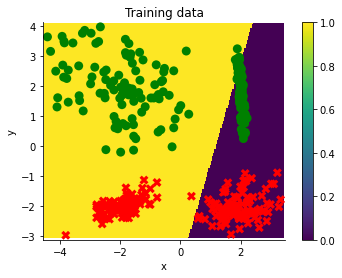

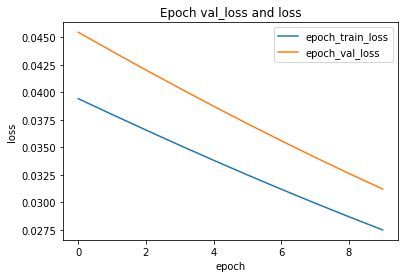

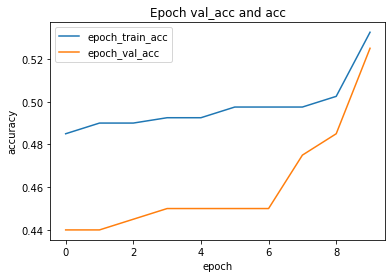


Avg. validation accuracy:0.461
Pytorch FC: dataset= 1
Convert from -1,1 to 0,1
Loading X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X torch.Size([200, 2]) y torch.Size([200]) classes {0.0, 1.0}


# Trial 0
epoch: 0 | TRAIN: loss 0.0294 acc 0.2325 | VALI: loss 0.03074 acc 0.255
epoch: 1 | TRAIN: loss 0.02711 acc 0.3325 | VALI: loss 0.02831 acc 0.36
epoch: 2 | TRAIN: loss 0.02515 acc 0.44 | VALI: loss 0.02622 acc 0.48
epoch: 3 | TRAIN: loss 0.02348 acc 0.5275 | VALI: loss 0.02441 acc 0.525
epoch: 4 | TRAIN: loss 0.02204 acc 0.5575 | VALI: loss 0.02283 acc 0.57
epoch: 5 | TRAIN: loss 0.02077 acc 0.6325 | VALI: loss 0.02141 acc 0.775
epoch: 6 | TRAIN: loss 0.01964 acc 0.7475 | VALI: loss 0.02013 acc 0.775
epoch: 7 | TRAIN: loss 0.01861 acc 0.75 | VALI: loss 0.01896 acc 0.775
epoch: 8 | TRAIN: loss 0.01767 acc 0.75 | VALI: loss 0.01789 acc 0.775
epoch: 9 | TRAIN: loss 0.0168 acc 0.75 | VALI: loss 0.01691 acc 0.775



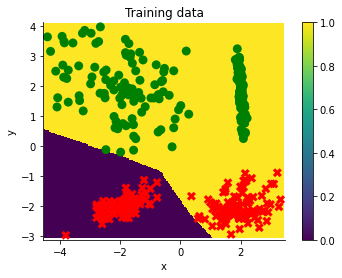

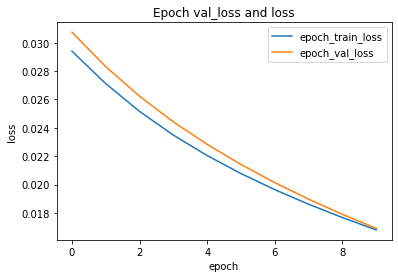

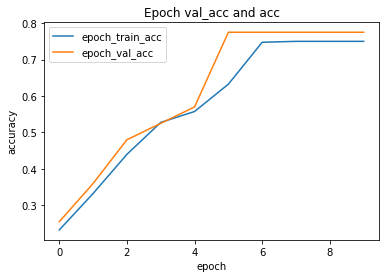


Avg. validation accuracy:0.6065
Pytorch FC: dataset= 1
Convert from -1,1 to 0,1
Loading X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X torch.Size([200, 2]) y torch.Size([200]) classes {0.0, 1.0}


# Trial 0
epoch: 0 | TRAIN: loss 0.02268 acc 0.5875 | VALI: loss 0.01565 acc 1.0
epoch: 1 | TRAIN: loss 0.01083 acc 0.9975 | VALI: loss 0.00823 acc 1.0
epoch: 2 | TRAIN: loss 0.00632 acc 0.9925 | VALI: loss 0.0052 acc 1.0
epoch: 3 | TRAIN: loss 0.0043 acc 0.9925 | VALI: loss 0.00366 acc 1.0
epoch: 4 | TRAIN: loss 0.0032 acc 0.9925 | VALI: loss 0.00279 acc 1.0
epoch: 5 | TRAIN: loss 0.00254 acc 0.995 | VALI: loss 0.00223 acc 1.0
epoch: 6 | TRAIN: loss 0.0021 acc 0.9975 | VALI: loss 0.00184 acc 1.0
epoch: 7 | TRAIN: loss 0.00177 acc 1.0 | VALI: loss 0.00156 acc 1.0
epoch: 8 | TRAIN: loss 0.00153 acc 1.0 | VALI: loss 0.00134 acc 1.0
epoch: 9 | TRAIN: loss 0.00134 acc 1.0 | VALI: loss 0.00117 acc 1.0



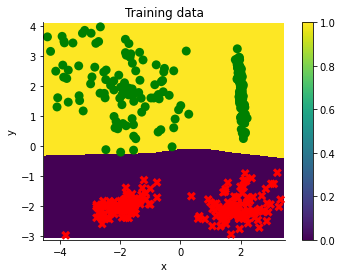

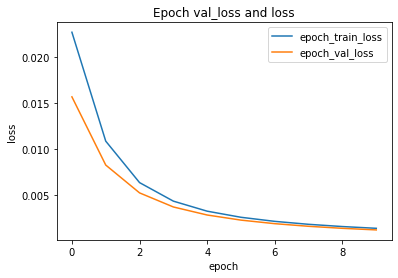

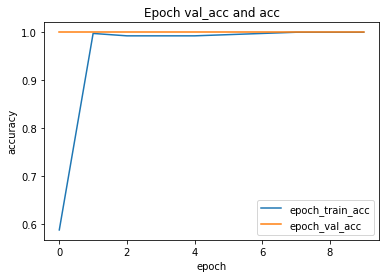


Avg. validation accuracy:1.0
Pytorch FC: dataset= 1
Convert from -1,1 to 0,1
Loading X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X torch.Size([200, 2]) y torch.Size([200]) classes {0.0, 1.0}


# Trial 0
epoch: 0 | TRAIN: loss 0.02102 acc 0.735 | VALI: loss 0.01654 acc 0.97
epoch: 1 | TRAIN: loss 0.012 acc 0.985 | VALI: loss 0.00885 acc 1.0
epoch: 2 | TRAIN: loss 0.00654 acc 0.9925 | VALI: loss 0.00473 acc 1.0
epoch: 3 | TRAIN: loss 0.00374 acc 0.9975 | VALI: loss 0.00276 acc 1.0
epoch: 4 | TRAIN: loss 0.00238 acc 1.0 | VALI: loss 0.00182 acc 1.0
epoch: 5 | TRAIN: loss 0.00168 acc 1.0 | VALI: loss 0.00131 acc 1.0
epoch: 6 | TRAIN: loss 0.00127 acc 1.0 | VALI: loss 0.001 acc 1.0
epoch: 7 | TRAIN: loss 0.00101 acc 1.0 | VALI: loss 0.0008 acc 1.0
epoch: 8 | TRAIN: loss 0.00083 acc 1.0 | VALI: loss 0.00065 acc 1.0
epoch: 9 | TRAIN: loss 0.0007 acc 1.0 | VALI: loss 0.00055 acc 1.0



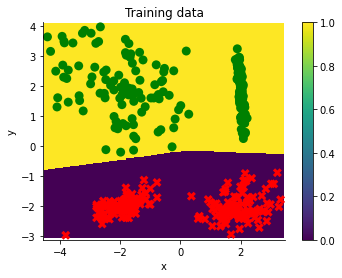

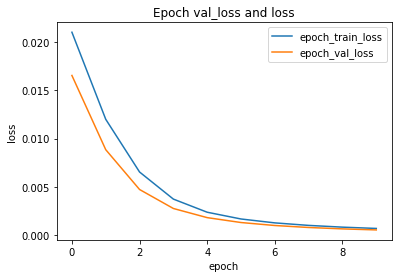

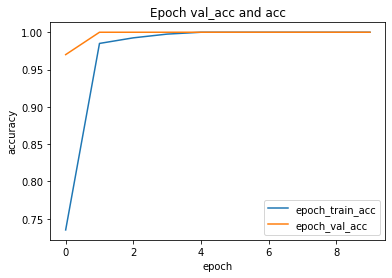


Avg. validation accuracy:0.9969999999999999
[]
Pytorch FC: dataset= 3
Convert from -1,1 to 0,1
Loading X torch.Size([400, 2]) y torch.Size([400]) classes {0.0, 1.0}
Convert from -1,1 to 0,1
Loading X torch.Size([200, 2]) y torch.Size([200]) classes {0.0, 1.0}


# Trial 0
epoch: 0 | TRAIN: loss 0.01481 acc 0.865 | VALI: loss 0.01505 acc 0.88
epoch: 1 | TRAIN: loss 0.01445 acc 0.885 | VALI: loss 0.01474 acc 0.885
epoch: 2 | TRAIN: loss 0.01411 acc 0.895 | VALI: loss 0.01444 acc 0.9
epoch: 3 | TRAIN: loss 0.01378 acc 0.915 | VALI: loss 0.01415 acc 0.905
epoch: 4 | TRAIN: loss 0.01347 acc 0.9225 | VALI: loss 0.01388 acc 0.905
epoch: 5 | TRAIN: loss 0.01317 acc 0.9325 | VALI: loss 0.01361 acc 0.915
epoch: 6 | TRAIN: loss 0.01289 acc 0.9325 | VALI: loss 0.01336 acc 0.925
epoch: 7 | TRAIN: loss 0.01261 acc 0.935 | VALI: loss 0.01312 acc 0.925
epoch: 8 | TRAIN: loss 0.01235 acc 0.94 | VALI: loss 0.01289 acc 0.925
epoch: 9 | TRAIN: loss 0.0121 acc 0.94 | VALI: loss 0.01267 acc 0.93



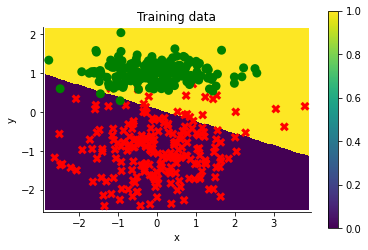

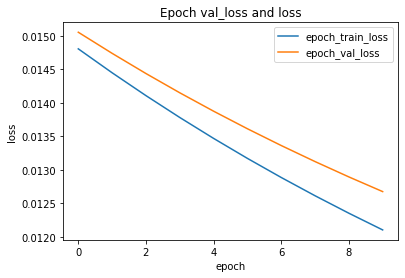

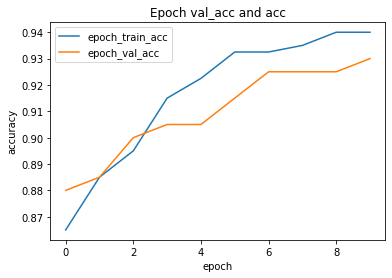



# Trial 1
epoch: 0 | TRAIN: loss 0.02414 acc 0.52 | VALI: loss 0.02575 acc 0.495
epoch: 1 | TRAIN: loss 0.02365 acc 0.52 | VALI: loss 0.02526 acc 0.495
epoch: 2 | TRAIN: loss 0.02318 acc 0.52 | VALI: loss 0.02479 acc 0.495
epoch: 3 | TRAIN: loss 0.02272 acc 0.52 | VALI: loss 0.02433 acc 0.495
epoch: 4 | TRAIN: loss 0.02227 acc 0.52 | VALI: loss 0.02388 acc 0.495
epoch: 5 | TRAIN: loss 0.02184 acc 0.5225 | VALI: loss 0.02344 acc 0.5
epoch: 6 | TRAIN: loss 0.02142 acc 0.5225 | VALI: loss 0.02302 acc 0.505
epoch: 7 | TRAIN: loss 0.02101 acc 0.5275 | VALI: loss 0.02261 acc 0.515
epoch: 8 | TRAIN: loss 0.02062 acc 0.5525 | VALI: loss 0.02221 acc 0.535
epoch: 9 | TRAIN: loss 0.02024 acc 0.5775 | VALI: loss 0.02182 acc 0.57



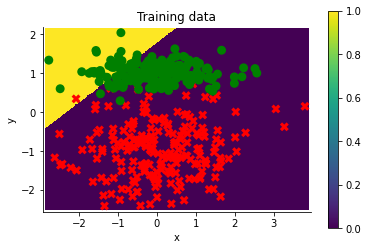

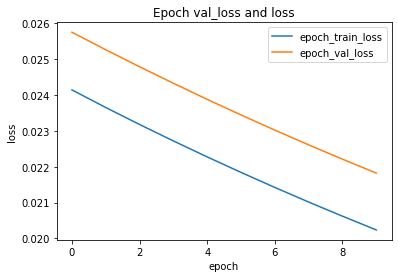

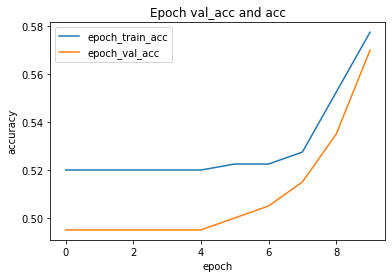



# Trial 2
epoch: 0 | TRAIN: loss 0.02184 acc 0.52 | VALI: loss 0.02326 acc 0.495
epoch: 1 | TRAIN: loss 0.02142 acc 0.5275 | VALI: loss 0.02285 acc 0.56
epoch: 2 | TRAIN: loss 0.02101 acc 0.66 | VALI: loss 0.02245 acc 0.735
epoch: 3 | TRAIN: loss 0.02061 acc 0.83 | VALI: loss 0.02205 acc 0.83
epoch: 4 | TRAIN: loss 0.02022 acc 0.9075 | VALI: loss 0.02167 acc 0.9
epoch: 5 | TRAIN: loss 0.01985 acc 0.94 | VALI: loss 0.0213 acc 0.935
epoch: 6 | TRAIN: loss 0.01948 acc 0.96 | VALI: loss 0.02094 acc 0.935
epoch: 7 | TRAIN: loss 0.01913 acc 0.9675 | VALI: loss 0.02059 acc 0.945
epoch: 8 | TRAIN: loss 0.01879 acc 0.9675 | VALI: loss 0.02025 acc 0.95
epoch: 9 | TRAIN: loss 0.01845 acc 0.9625 | VALI: loss 0.01991 acc 0.95



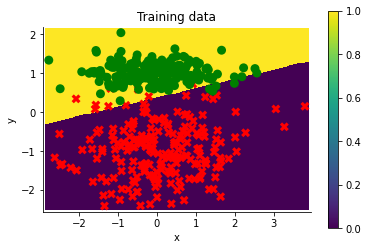

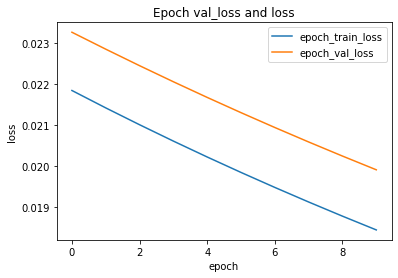

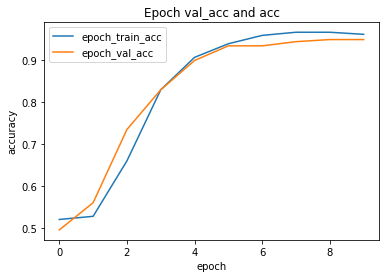



# Trial 3
epoch: 0 | TRAIN: loss 0.03577 acc 0.065 | VALI: loss 0.03787 acc 0.06
epoch: 1 | TRAIN: loss 0.03517 acc 0.0675 | VALI: loss 0.03727 acc 0.06
epoch: 2 | TRAIN: loss 0.03458 acc 0.07 | VALI: loss 0.03667 acc 0.065
epoch: 3 | TRAIN: loss 0.034 acc 0.0725 | VALI: loss 0.03609 acc 0.065
epoch: 4 | TRAIN: loss 0.03343 acc 0.0725 | VALI: loss 0.03551 acc 0.065
epoch: 5 | TRAIN: loss 0.03287 acc 0.0725 | VALI: loss 0.03494 acc 0.065
epoch: 6 | TRAIN: loss 0.03232 acc 0.075 | VALI: loss 0.03438 acc 0.065
epoch: 7 | TRAIN: loss 0.03178 acc 0.0825 | VALI: loss 0.03383 acc 0.065
epoch: 8 | TRAIN: loss 0.03125 acc 0.0825 | VALI: loss 0.03329 acc 0.07
epoch: 9 | TRAIN: loss 0.03073 acc 0.09 | VALI: loss 0.03276 acc 0.07



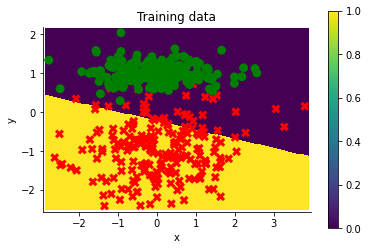

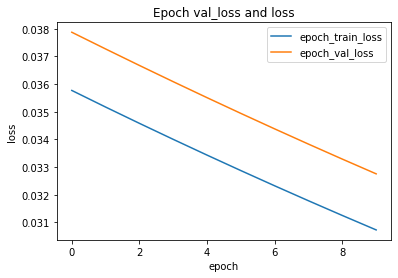

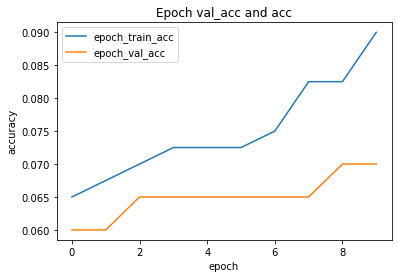



# Trial 4
epoch: 0 | TRAIN: loss 0.01535 acc 0.75 | VALI: loss 0.01702 acc 0.775
epoch: 1 | TRAIN: loss 0.01497 acc 0.77 | VALI: loss 0.01661 acc 0.79
epoch: 2 | TRAIN: loss 0.0146 acc 0.7875 | VALI: loss 0.01622 acc 0.805
epoch: 3 | TRAIN: loss 0.01425 acc 0.8075 | VALI: loss 0.01585 acc 0.82
epoch: 4 | TRAIN: loss 0.01391 acc 0.825 | VALI: loss 0.01549 acc 0.825
epoch: 5 | TRAIN: loss 0.01359 acc 0.8425 | VALI: loss 0.01515 acc 0.855
epoch: 6 | TRAIN: loss 0.01328 acc 0.8675 | VALI: loss 0.01483 acc 0.875
epoch: 7 | TRAIN: loss 0.01299 acc 0.87 | VALI: loss 0.01451 acc 0.88
epoch: 8 | TRAIN: loss 0.01271 acc 0.88 | VALI: loss 0.01422 acc 0.88
epoch: 9 | TRAIN: loss 0.01245 acc 0.885 | VALI: loss 0.01393 acc 0.88



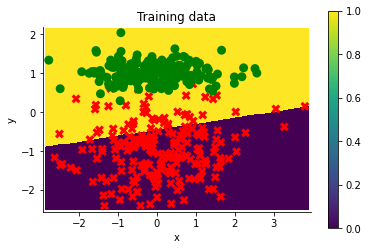

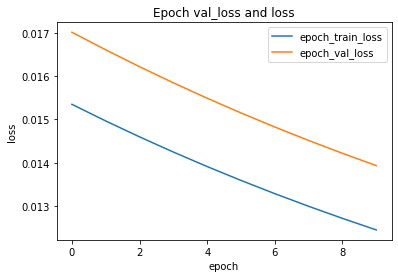

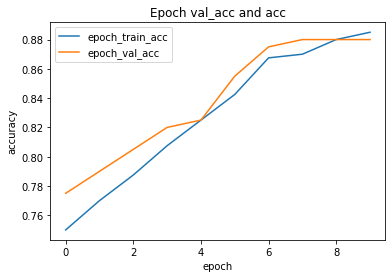



# Trial 5
epoch: 0 | TRAIN: loss 0.01993 acc 0.5625 | VALI: loss 0.0216 acc 0.54
epoch: 1 | TRAIN: loss 0.0195 acc 0.58 | VALI: loss 0.02115 acc 0.56
epoch: 2 | TRAIN: loss 0.01908 acc 0.615 | VALI: loss 0.02071 acc 0.59
epoch: 3 | TRAIN: loss 0.01867 acc 0.65 | VALI: loss 0.02029 acc 0.6
epoch: 4 | TRAIN: loss 0.01828 acc 0.6825 | VALI: loss 0.01989 acc 0.63
epoch: 5 | TRAIN: loss 0.01791 acc 0.7125 | VALI: loss 0.0195 acc 0.685
epoch: 6 | TRAIN: loss 0.01754 acc 0.7475 | VALI: loss 0.01912 acc 0.705
epoch: 7 | TRAIN: loss 0.01719 acc 0.775 | VALI: loss 0.01876 acc 0.76
epoch: 8 | TRAIN: loss 0.01686 acc 0.8075 | VALI: loss 0.01841 acc 0.775
epoch: 9 | TRAIN: loss 0.01653 acc 0.8525 | VALI: loss 0.01807 acc 0.82



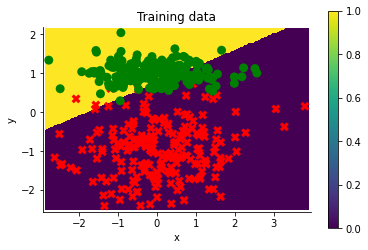

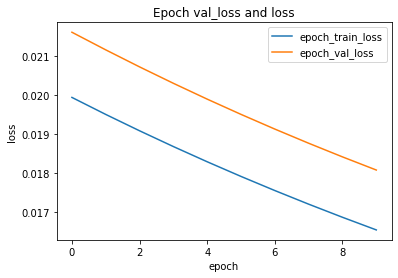

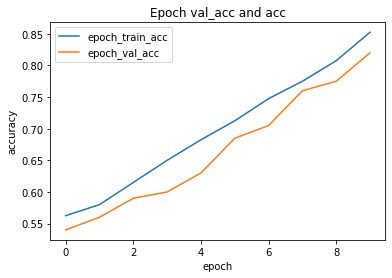



# Trial 6
epoch: 0 | TRAIN: loss 0.04604 acc 0.11 | VALI: loss 0.04954 acc 0.085
epoch: 1 | TRAIN: loss 0.04537 acc 0.11 | VALI: loss 0.04882 acc 0.085
epoch: 2 | TRAIN: loss 0.0447 acc 0.1125 | VALI: loss 0.0481 acc 0.085
epoch: 3 | TRAIN: loss 0.04404 acc 0.115 | VALI: loss 0.0474 acc 0.085
epoch: 4 | TRAIN: loss 0.04339 acc 0.1175 | VALI: loss 0.0467 acc 0.085
epoch: 5 | TRAIN: loss 0.04275 acc 0.1175 | VALI: loss 0.046 acc 0.085
epoch: 6 | TRAIN: loss 0.04211 acc 0.1175 | VALI: loss 0.04532 acc 0.085
epoch: 7 | TRAIN: loss 0.04148 acc 0.1175 | VALI: loss 0.04464 acc 0.085
epoch: 8 | TRAIN: loss 0.04085 acc 0.1175 | VALI: loss 0.04397 acc 0.09
epoch: 9 | TRAIN: loss 0.04024 acc 0.1175 | VALI: loss 0.04331 acc 0.095



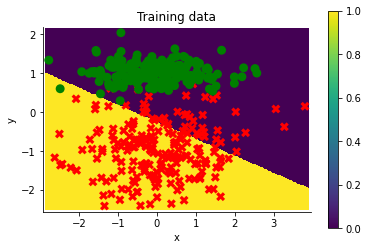

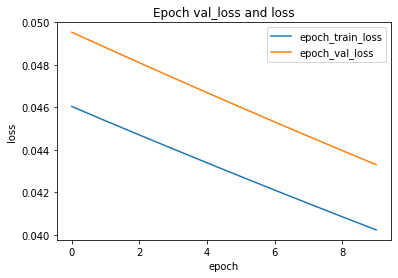

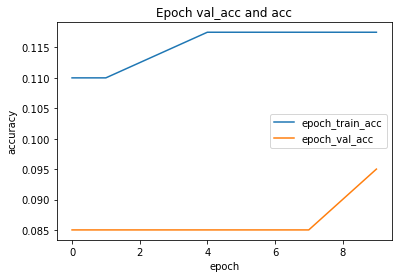



# Trial 7
epoch: 0 | TRAIN: loss 0.02438 acc 0.46 | VALI: loss 0.0247 acc 0.525
epoch: 1 | TRAIN: loss 0.02384 acc 0.4775 | VALI: loss 0.02422 acc 0.545
epoch: 2 | TRAIN: loss 0.02333 acc 0.5075 | VALI: loss 0.02374 acc 0.55
epoch: 3 | TRAIN: loss 0.02283 acc 0.53 | VALI: loss 0.02328 acc 0.58
epoch: 4 | TRAIN: loss 0.02234 acc 0.56 | VALI: loss 0.02284 acc 0.615
epoch: 5 | TRAIN: loss 0.02187 acc 0.5775 | VALI: loss 0.0224 acc 0.635
epoch: 6 | TRAIN: loss 0.02141 acc 0.5975 | VALI: loss 0.02198 acc 0.67
epoch: 7 | TRAIN: loss 0.02097 acc 0.64 | VALI: loss 0.02158 acc 0.71
epoch: 8 | TRAIN: loss 0.02054 acc 0.6575 | VALI: loss 0.02118 acc 0.73
epoch: 9 | TRAIN: loss 0.02012 acc 0.6875 | VALI: loss 0.0208 acc 0.74



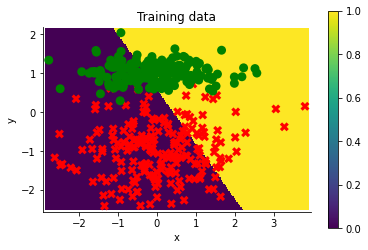

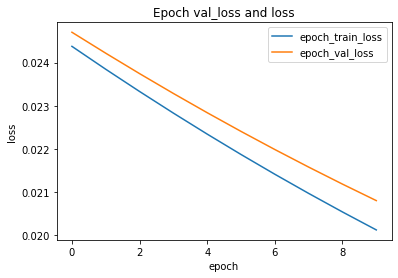

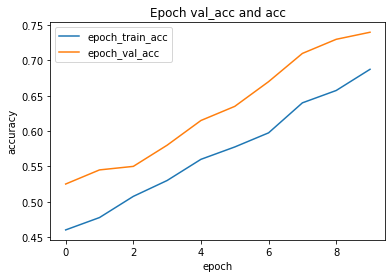



# Trial 8
epoch: 0 | TRAIN: loss 0.01178 acc 0.95 | VALI: loss 0.0125 acc 0.94
epoch: 1 | TRAIN: loss 0.01153 acc 0.9525 | VALI: loss 0.01227 acc 0.945
epoch: 2 | TRAIN: loss 0.01129 acc 0.9525 | VALI: loss 0.01206 acc 0.945
epoch: 3 | TRAIN: loss 0.01106 acc 0.955 | VALI: loss 0.01186 acc 0.945
epoch: 4 | TRAIN: loss 0.01084 acc 0.96 | VALI: loss 0.01167 acc 0.95
epoch: 5 | TRAIN: loss 0.01064 acc 0.96 | VALI: loss 0.01148 acc 0.95
epoch: 6 | TRAIN: loss 0.01044 acc 0.96 | VALI: loss 0.01131 acc 0.95
epoch: 7 | TRAIN: loss 0.01025 acc 0.96 | VALI: loss 0.01114 acc 0.95
epoch: 8 | TRAIN: loss 0.01007 acc 0.96 | VALI: loss 0.01097 acc 0.95
epoch: 9 | TRAIN: loss 0.00989 acc 0.9575 | VALI: loss 0.01082 acc 0.945



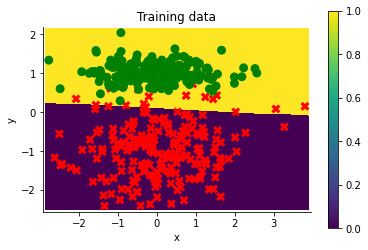

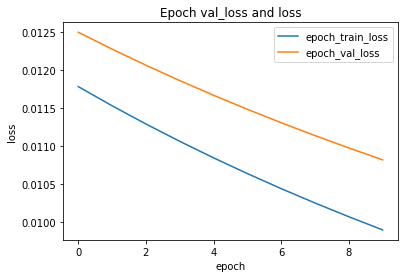

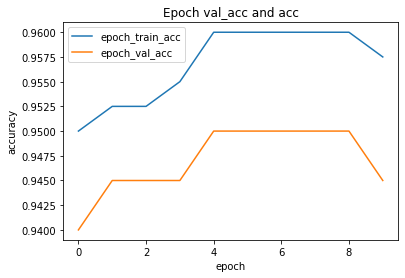



# Trial 9
epoch: 0 | TRAIN: loss 0.01347 acc 0.895 | VALI: loss 0.01534 acc 0.885
epoch: 1 | TRAIN: loss 0.01316 acc 0.9025 | VALI: loss 0.015 acc 0.9
epoch: 2 | TRAIN: loss 0.01287 acc 0.915 | VALI: loss 0.01467 acc 0.895
epoch: 3 | TRAIN: loss 0.0126 acc 0.9225 | VALI: loss 0.01436 acc 0.905
epoch: 4 | TRAIN: loss 0.01233 acc 0.9275 | VALI: loss 0.01407 acc 0.91
epoch: 5 | TRAIN: loss 0.01208 acc 0.9375 | VALI: loss 0.01378 acc 0.92
epoch: 6 | TRAIN: loss 0.01185 acc 0.945 | VALI: loss 0.01352 acc 0.925
epoch: 7 | TRAIN: loss 0.01162 acc 0.945 | VALI: loss 0.01326 acc 0.93
epoch: 8 | TRAIN: loss 0.0114 acc 0.9475 | VALI: loss 0.01302 acc 0.93
epoch: 9 | TRAIN: loss 0.0112 acc 0.9525 | VALI: loss 0.01278 acc 0.925



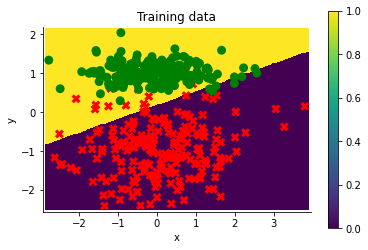

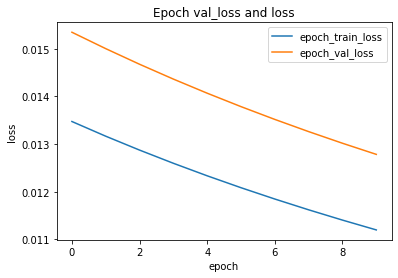

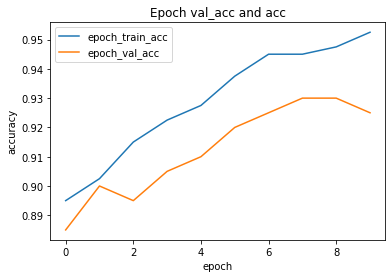



# Trial 10
epoch: 0 | TRAIN: loss 0.0222 acc 0.52 | VALI: loss 0.02389 acc 0.495
epoch: 1 | TRAIN: loss 0.02167 acc 0.5225 | VALI: loss 0.02334 acc 0.495
epoch: 2 | TRAIN: loss 0.02117 acc 0.5225 | VALI: loss 0.02282 acc 0.495
epoch: 3 | TRAIN: loss 0.02067 acc 0.5225 | VALI: loss 0.02231 acc 0.5
epoch: 4 | TRAIN: loss 0.0202 acc 0.5225 | VALI: loss 0.02181 acc 0.505
epoch: 5 | TRAIN: loss 0.01973 acc 0.53 | VALI: loss 0.02133 acc 0.505
epoch: 6 | TRAIN: loss 0.01928 acc 0.53 | VALI: loss 0.02086 acc 0.515
epoch: 7 | TRAIN: loss 0.01885 acc 0.5375 | VALI: loss 0.02041 acc 0.52
epoch: 8 | TRAIN: loss 0.01843 acc 0.55 | VALI: loss 0.01997 acc 0.53
epoch: 9 | TRAIN: loss 0.01802 acc 0.5675 | VALI: loss 0.01955 acc 0.545



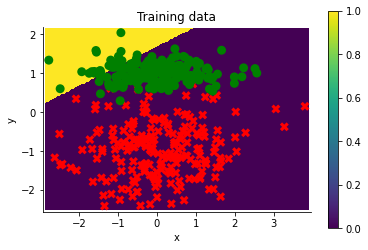

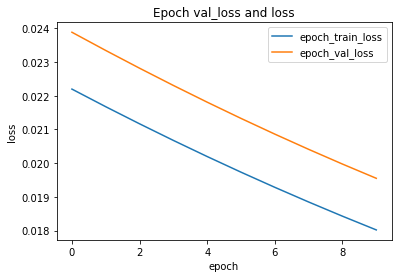

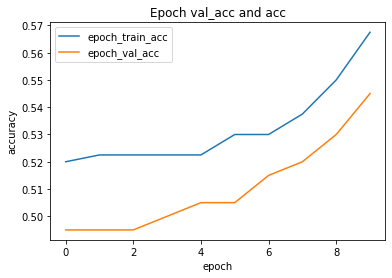



# Trial 11
epoch: 0 | TRAIN: loss 0.04237 acc 0.1725 | VALI: loss 0.04517 acc 0.165
epoch: 1 | TRAIN: loss 0.04168 acc 0.1725 | VALI: loss 0.04447 acc 0.165
epoch: 2 | TRAIN: loss 0.04102 acc 0.175 | VALI: loss 0.04377 acc 0.165
epoch: 3 | TRAIN: loss 0.04036 acc 0.175 | VALI: loss 0.04308 acc 0.165
epoch: 4 | TRAIN: loss 0.03971 acc 0.175 | VALI: loss 0.0424 acc 0.17
epoch: 5 | TRAIN: loss 0.03907 acc 0.175 | VALI: loss 0.04173 acc 0.175
epoch: 6 | TRAIN: loss 0.03844 acc 0.18 | VALI: loss 0.04107 acc 0.175
epoch: 7 | TRAIN: loss 0.03781 acc 0.18 | VALI: loss 0.04042 acc 0.175
epoch: 8 | TRAIN: loss 0.0372 acc 0.1825 | VALI: loss 0.03978 acc 0.185
epoch: 9 | TRAIN: loss 0.03659 acc 0.1825 | VALI: loss 0.03914 acc 0.185



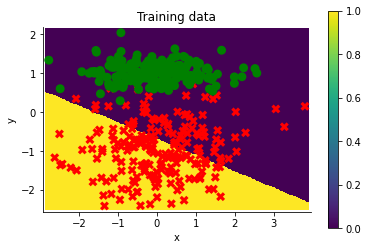

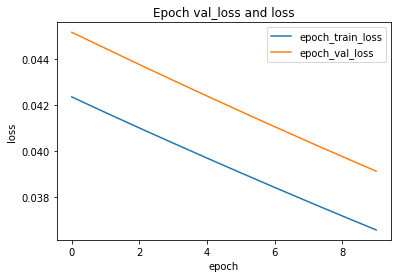

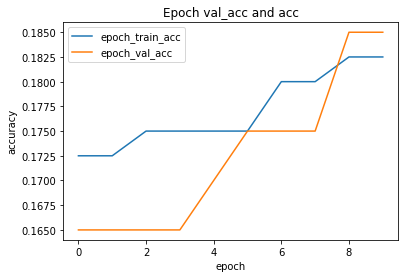



# Trial 12
epoch: 0 | TRAIN: loss 0.03651 acc 0.3575 | VALI: loss 0.03898 acc 0.385
epoch: 1 | TRAIN: loss 0.0358 acc 0.3675 | VALI: loss 0.03826 acc 0.38
epoch: 2 | TRAIN: loss 0.03511 acc 0.3725 | VALI: loss 0.03754 acc 0.39
epoch: 3 | TRAIN: loss 0.03443 acc 0.3875 | VALI: loss 0.03684 acc 0.4
epoch: 4 | TRAIN: loss 0.03377 acc 0.39 | VALI: loss 0.03616 acc 0.405
epoch: 5 | TRAIN: loss 0.03312 acc 0.3875 | VALI: loss 0.03548 acc 0.405
epoch: 6 | TRAIN: loss 0.03248 acc 0.4 | VALI: loss 0.03482 acc 0.41
epoch: 7 | TRAIN: loss 0.03186 acc 0.405 | VALI: loss 0.03417 acc 0.42
epoch: 8 | TRAIN: loss 0.03124 acc 0.41 | VALI: loss 0.03353 acc 0.425
epoch: 9 | TRAIN: loss 0.03064 acc 0.4125 | VALI: loss 0.03291 acc 0.425



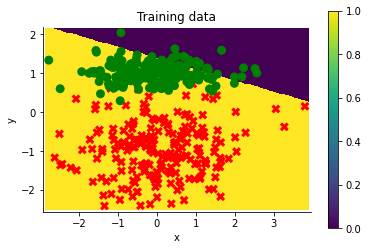

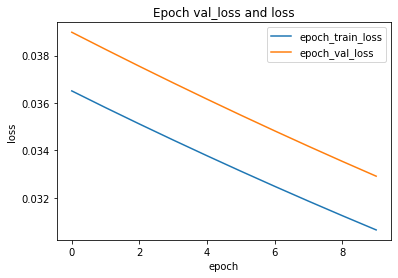

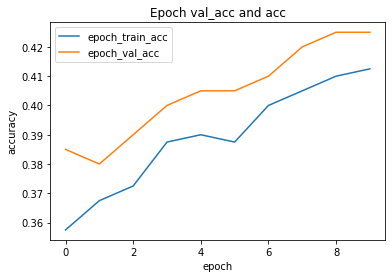



# Trial 13
epoch: 0 | TRAIN: loss 0.02683 acc 0.48 | VALI: loss 0.02891 acc 0.505
epoch: 1 | TRAIN: loss 0.02622 acc 0.48 | VALI: loss 0.02828 acc 0.505
epoch: 2 | TRAIN: loss 0.02563 acc 0.48 | VALI: loss 0.02767 acc 0.505
epoch: 3 | TRAIN: loss 0.02505 acc 0.48 | VALI: loss 0.02707 acc 0.505
epoch: 4 | TRAIN: loss 0.0245 acc 0.48 | VALI: loss 0.02649 acc 0.505
epoch: 5 | TRAIN: loss 0.02395 acc 0.48 | VALI: loss 0.02593 acc 0.505
epoch: 6 | TRAIN: loss 0.02343 acc 0.48 | VALI: loss 0.02539 acc 0.505
epoch: 7 | TRAIN: loss 0.02292 acc 0.48 | VALI: loss 0.02486 acc 0.505
epoch: 8 | TRAIN: loss 0.02243 acc 0.48 | VALI: loss 0.02434 acc 0.505
epoch: 9 | TRAIN: loss 0.02195 acc 0.48 | VALI: loss 0.02385 acc 0.505



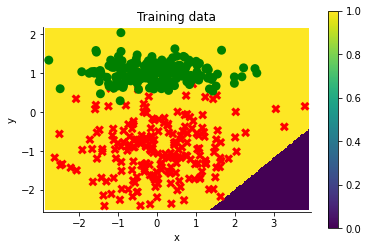

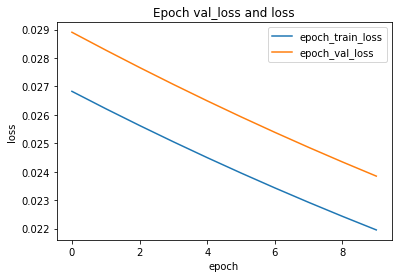

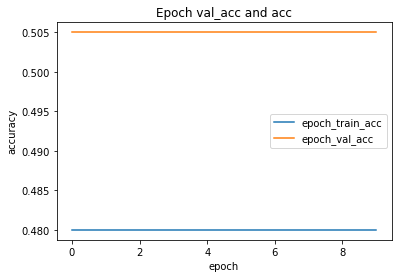



# Trial 14
epoch: 0 | TRAIN: loss 0.03519 acc 0.28 | VALI: loss 0.03682 acc 0.27
epoch: 1 | TRAIN: loss 0.03454 acc 0.28 | VALI: loss 0.03618 acc 0.27
epoch: 2 | TRAIN: loss 0.0339 acc 0.285 | VALI: loss 0.03555 acc 0.275
epoch: 3 | TRAIN: loss 0.03328 acc 0.29 | VALI: loss 0.03494 acc 0.285
epoch: 4 | TRAIN: loss 0.03268 acc 0.29 | VALI: loss 0.03434 acc 0.285
epoch: 5 | TRAIN: loss 0.03208 acc 0.3025 | VALI: loss 0.03375 acc 0.29
epoch: 6 | TRAIN: loss 0.03149 acc 0.315 | VALI: loss 0.03317 acc 0.295
epoch: 7 | TRAIN: loss 0.03092 acc 0.3225 | VALI: loss 0.0326 acc 0.31
epoch: 8 | TRAIN: loss 0.03036 acc 0.33 | VALI: loss 0.03205 acc 0.31
epoch: 9 | TRAIN: loss 0.02981 acc 0.345 | VALI: loss 0.0315 acc 0.325



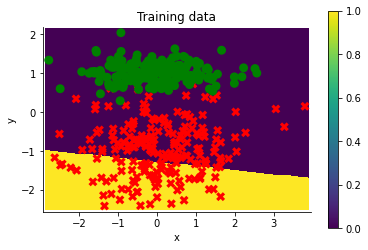

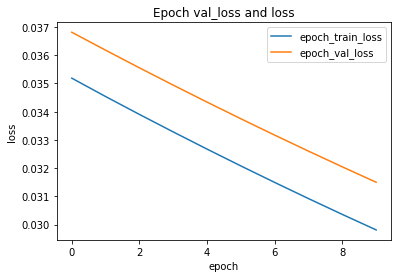

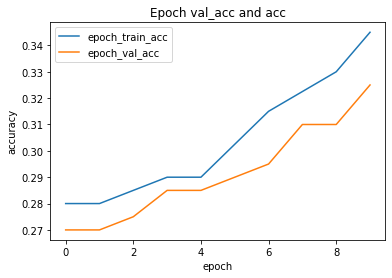



# Trial 15
epoch: 0 | TRAIN: loss 0.01034 acc 0.9625 | VALI: loss 0.01102 acc 0.955
epoch: 1 | TRAIN: loss 0.01012 acc 0.965 | VALI: loss 0.01083 acc 0.96
epoch: 2 | TRAIN: loss 0.00991 acc 0.9675 | VALI: loss 0.01065 acc 0.96
epoch: 3 | TRAIN: loss 0.00972 acc 0.9675 | VALI: loss 0.01048 acc 0.96
epoch: 4 | TRAIN: loss 0.00953 acc 0.97 | VALI: loss 0.01032 acc 0.96
epoch: 5 | TRAIN: loss 0.00935 acc 0.9675 | VALI: loss 0.01016 acc 0.96
epoch: 6 | TRAIN: loss 0.00918 acc 0.965 | VALI: loss 0.01002 acc 0.96
epoch: 7 | TRAIN: loss 0.00902 acc 0.965 | VALI: loss 0.00988 acc 0.95
epoch: 8 | TRAIN: loss 0.00887 acc 0.9675 | VALI: loss 0.00974 acc 0.95
epoch: 9 | TRAIN: loss 0.00872 acc 0.9675 | VALI: loss 0.00961 acc 0.95



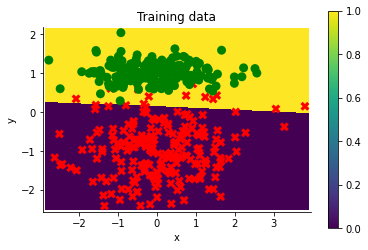

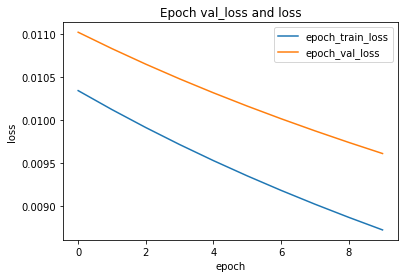

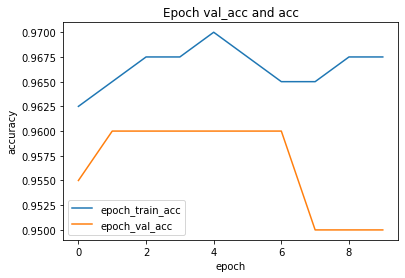



# Trial 16
epoch: 0 | TRAIN: loss 0.0247 acc 0.5175 | VALI: loss 0.02794 acc 0.475
epoch: 1 | TRAIN: loss 0.02413 acc 0.5325 | VALI: loss 0.02728 acc 0.48
epoch: 2 | TRAIN: loss 0.02357 acc 0.5425 | VALI: loss 0.02665 acc 0.49
epoch: 3 | TRAIN: loss 0.02303 acc 0.555 | VALI: loss 0.02603 acc 0.495
epoch: 4 | TRAIN: loss 0.02251 acc 0.5725 | VALI: loss 0.02543 acc 0.52
epoch: 5 | TRAIN: loss 0.02201 acc 0.5775 | VALI: loss 0.02486 acc 0.545
epoch: 6 | TRAIN: loss 0.02152 acc 0.6075 | VALI: loss 0.0243 acc 0.57
epoch: 7 | TRAIN: loss 0.02105 acc 0.6175 | VALI: loss 0.02376 acc 0.6
epoch: 8 | TRAIN: loss 0.02059 acc 0.635 | VALI: loss 0.02324 acc 0.62
epoch: 9 | TRAIN: loss 0.02016 acc 0.6625 | VALI: loss 0.02274 acc 0.645



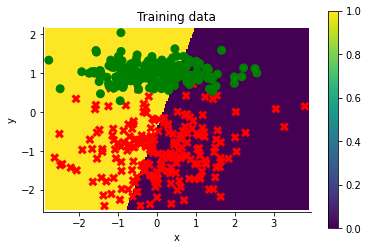

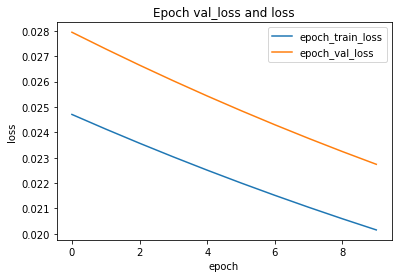

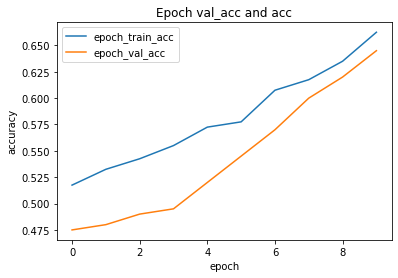



# Trial 17
epoch: 0 | TRAIN: loss 0.01219 acc 0.9 | VALI: loss 0.01397 acc 0.89
epoch: 1 | TRAIN: loss 0.0119 acc 0.9075 | VALI: loss 0.01363 acc 0.895
epoch: 2 | TRAIN: loss 0.01162 acc 0.9125 | VALI: loss 0.01331 acc 0.895
epoch: 3 | TRAIN: loss 0.01136 acc 0.915 | VALI: loss 0.01301 acc 0.9
epoch: 4 | TRAIN: loss 0.01111 acc 0.92 | VALI: loss 0.01272 acc 0.905
epoch: 5 | TRAIN: loss 0.01088 acc 0.93 | VALI: loss 0.01245 acc 0.905
epoch: 6 | TRAIN: loss 0.01066 acc 0.9325 | VALI: loss 0.0122 acc 0.905
epoch: 7 | TRAIN: loss 0.01045 acc 0.935 | VALI: loss 0.01196 acc 0.91
epoch: 8 | TRAIN: loss 0.01025 acc 0.9425 | VALI: loss 0.01173 acc 0.915
epoch: 9 | TRAIN: loss 0.01006 acc 0.95 | VALI: loss 0.01152 acc 0.915



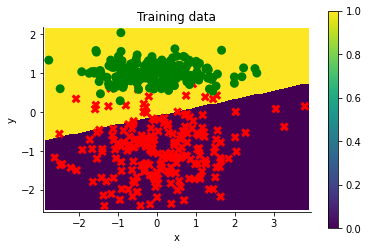

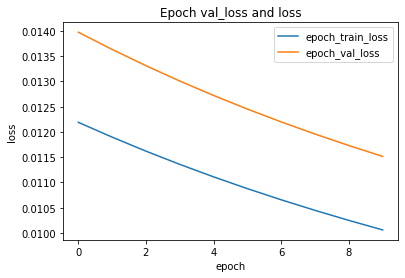

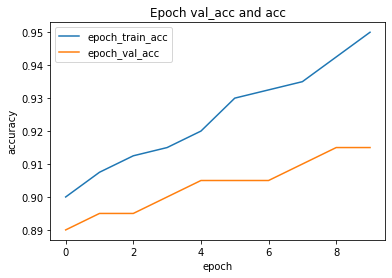



# Trial 18
epoch: 0 | TRAIN: loss 0.04819 acc 0.065 | VALI: loss 0.04937 acc 0.1
epoch: 1 | TRAIN: loss 0.04744 acc 0.065 | VALI: loss 0.04866 acc 0.1
epoch: 2 | TRAIN: loss 0.04671 acc 0.065 | VALI: loss 0.04795 acc 0.1
epoch: 3 | TRAIN: loss 0.04599 acc 0.065 | VALI: loss 0.04725 acc 0.1
epoch: 4 | TRAIN: loss 0.04528 acc 0.065 | VALI: loss 0.04656 acc 0.1
epoch: 5 | TRAIN: loss 0.04457 acc 0.0675 | VALI: loss 0.04588 acc 0.1
epoch: 6 | TRAIN: loss 0.04388 acc 0.0675 | VALI: loss 0.04521 acc 0.1
epoch: 7 | TRAIN: loss 0.04319 acc 0.07 | VALI: loss 0.04454 acc 0.1
epoch: 8 | TRAIN: loss 0.04251 acc 0.07 | VALI: loss 0.04388 acc 0.1
epoch: 9 | TRAIN: loss 0.04184 acc 0.07 | VALI: loss 0.04323 acc 0.1



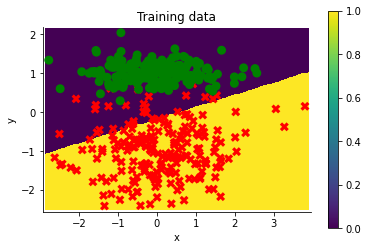

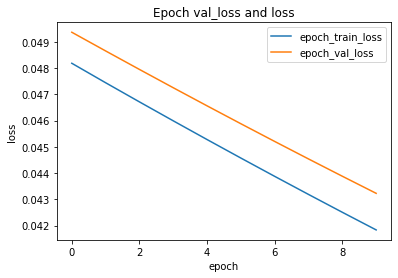

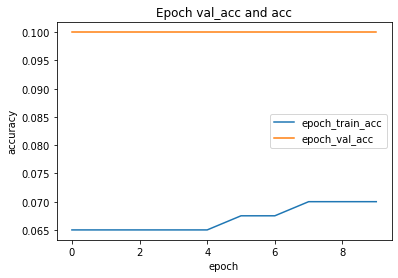



# Trial 19
epoch: 0 | TRAIN: loss 0.01439 acc 0.7725 | VALI: loss 0.01695 acc 0.735
epoch: 1 | TRAIN: loss 0.01397 acc 0.775 | VALI: loss 0.01648 acc 0.75
epoch: 2 | TRAIN: loss 0.01357 acc 0.7875 | VALI: loss 0.01603 acc 0.755
epoch: 3 | TRAIN: loss 0.01319 acc 0.805 | VALI: loss 0.0156 acc 0.765
epoch: 4 | TRAIN: loss 0.01282 acc 0.815 | VALI: loss 0.01518 acc 0.775
epoch: 5 | TRAIN: loss 0.01246 acc 0.825 | VALI: loss 0.01478 acc 0.8
epoch: 6 | TRAIN: loss 0.01212 acc 0.8325 | VALI: loss 0.0144 acc 0.81
epoch: 7 | TRAIN: loss 0.01179 acc 0.835 | VALI: loss 0.01404 acc 0.815
epoch: 8 | TRAIN: loss 0.01148 acc 0.855 | VALI: loss 0.01368 acc 0.83
epoch: 9 | TRAIN: loss 0.01118 acc 0.8675 | VALI: loss 0.01335 acc 0.84



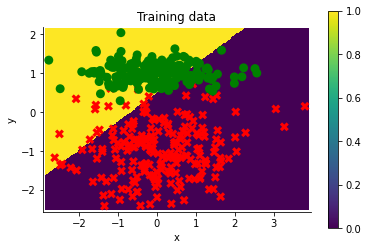

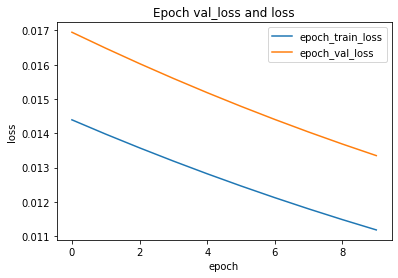

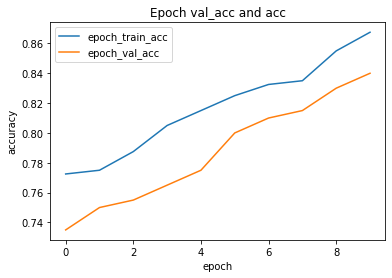


Avg. validation accuracy:0.578225


In [ ]:
layer_dict = archs(2) # implies we have 2 classification classes
layers = layer_dict[0] # using architecture 0


accuracies = []
for layer_ix in range(0, 4):
  layer = layer_dict[layer_ix]
  run_pytorch_2d("1", layer, epochs=10, trials = 1, verbose=True, display=True)
print(accuracies)

test_set_number = "3"
# this will train on dataset "1"
X_train, y_train, model = run_pytorch_2d(test_set_number, layers, epochs=10, trials = 20, verbose=True, display=True)

In [ ]:
# if you don't care about the return values, throw them into a trash variable
_ = run_pytorch_2d("3class",archs(3)[2], 10, split=.5, display=False, verbose=False, trials=20)

## 3E)

In [ ]:
points = np.array([[-1,0], [1,0], [0,-11], [0,1], [-1,-1], [-1,1], [1,1], [1,-1]])

deterministic = True
if deterministic:
  torch.manual_seed(10)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(10)

layer_dict = archs(3) # implies we have 2 classification classes
layers = layer_dict[0] # using architecture 0

X_train, y_train, model = run_pytorch_2d("3class", layers, epochs=100, trials=1, verbose=True, display=True)

# 4) Optimizers

In this question, we're going to return to the non-convex function from lab 3.

In [ ]:
import abc

import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
from io import BytesIO, StringIO
import base64

import plotly.graph_objects
import plotly.tools

In [ ]:
def tidy_plot(xmin, xmax, ymin, ymax, center = False, title = None,
                 xlabel = None, ylabel = None):
    plt.figure(facecolor="white")
    ax = plt.subplot()
    if center:
        ax.spines['left'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['bottom'].set_position('zero')
        ax.spines['top'].set_color('none')
        # ax.spines['left'].set_smart_bounds(True)	# 2021-07-26 no longer available
        # ax.spines['bottom'].set_smart_bounds(True)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
    else:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
    eps = .05
    plt.xlim(xmin-eps, xmax+eps)
    plt.ylim(ymin-eps, ymax+eps)
    if title: ax.set_title(title)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    return ax

def plot_fun(ax, f, xmin, xmax, nPts = 100, label = None):
    x = np.linspace(xmin, xmax, nPts)
    y = cv([float(f(xi)) for xi in x])
    ax.plot(x, y, label = label)
    return savefig()

def plot_points(x, y, ax = None, clear = False,
                  xmin = None, xmax = None, ymin = None, ymax = None,
                  style = 'or-', equal = False, mark_initial = False, mark_final = False):
    padup = lambda v: v + 0.05 * abs(v)
    paddown = lambda v: v - 0.05 * abs(v)
    if ax is None:
        if xmin == None: xmin = paddown(np.min(x))
        if xmax == None: xmax = padup(np.max(x))
        if ymin == None: ymin = paddown(np.min(y))
        if ymax == None: ymax = padup(np.max(y))
        ax = tidy_plot(xmin, xmax, ymin, ymax)
        x_range = xmax - xmin; y_range = ymax - ymin
        if equal and .1 < x_range / y_range < 10:
            #ax.set_aspect('equal')
            plt.axis('equal')
            if x_range > y_range:
                ax.set_xlim((xmin, xmax))
            else:
                ax.set_ylim((ymin, ymax))
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
    elif clear:
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
        ax.clear()
    else:
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.plot(x, y, style, markeredgewidth=0.0, linewidth = 3.0)
    if mark_initial:
      ax.plot(x[0], y[0], 'xb', markersize = 12)
    if mark_final:
      ax.plot(x[-1], y[-1], 'Db', markersize = 6)
    # Seems to occasionally mess up the limits
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.grid(True, which='both')
    return ax


def plotly2html(fig):
    '''
    Return HTML for plotly figure.
    Note that the plotly js library is NOT included; this must be added, e.g. in preload.py with

    cs_scripts += """<script type="text/javascript">window.PlotlyConfig = {MathJaxConfig: 'local'};</script>"""
    cs_scripts += """<script src="https://cdn.plot.ly/plotly-latest.min.js"></script>"""

    '''
    with StringIO() as ofp:
        fig.write_html(ofp, auto_open=False, include_plotlyjs=False, full_html=False)
        ofp.seek(0)
        fig_output = ofp.read()
    return fig_output


def savefig_plotly(legend=False, width=720, height=400):
    '''
    Attempt to generate a plotly figure from a matplotlib figure.
    Doesn't always work!
    '''
    def is_frame_like(self, *args, **kwargs):
        return False
    matplotlib.spines.Spine.is_frame_like = is_frame_like
    fig = plotly.tools.mpl_to_plotly(plt.gcf())
    if legend:
        fig['layout']['showlegend'] = True
    fig.update_layout(width=width, height=height)
    return plotly2html(fig)

def savefig():
    b = BytesIO()
    plt.savefig(b)
    return '<img style="width:600px" src="data:image/png;base64,%s" />' % base64.b64encode(b.getvalue()).decode()


def rv(value_list):
    return np.array([value_list])

def cv(value_list):
    return np.transpose(rv(value_list))

def add_ones(X):
    return np.vstack([X, np.ones(X.shape[1])])

In [ ]:
def f(x):
    return(x - 2.) * (x - 3.) * (x + 3.) * (x + 1.)

def fdf(x):
    return f(x), \
            9. - (22. * x) - (3. * x**2) + (4. * x**3)

In [ ]:
class Optimizer(abc.ABC):
    def __init__(self, shape, **kwargs):
        '''
        shape: tuple indicating the expected shape of the gradient
        '''
        pass

    @abc.abstractmethod
    def get_grad_step(self, t, gradient):
        pass


class GD(Optimizer):
    def __init__(self, shape):
        pass

    def get_grad_step(self, t, gradient):
        return gradient


class Adam(Optimizer):
    def __init__(self, shape):
        self.m = np.zeros(shape)
        self.v = np.zeros(shape)
        self.B1 = 0.9
        self.B2 = 0.999
        self.eps = 1e-8

    def get_grad_step(self, t, gradient):
        self.m = self.B1 * self.m + (1 - self.B1) * gradient
        self.v = self.B2 * self.v + (1- self.B2) * (gradient ** 2)
        m_hat = self.m / (1 - self.B1**t)
        v_hat = self.v / (1 - self.B2**t)
        return m_hat / np.sqrt(v_hat + self.eps)


def gd_with_optim(f_df, x0, step_size=.01, step_size_fn=None, max_iter=1000,
                  optim_cls=GD, eps=1e-5, hook=None):
    max_iter = min(max_iter,1000)
    prev_x = x0
    fs = []; xs = []

    optim = optim_cls(shape=x0.shape)

    for i in range(max_iter):
        prev_f, prev_grad = f_df(prev_x)
        if prev_grad is None:
            prev_grad = num_grad(lambda x: f_df(x)[0])(prev_x)

        fs.append(float(prev_f)); xs.append(prev_x)

        step = step_size_fn(i) if step_size_fn else step_size

        assert prev_x.shape == prev_grad.shape

        x = prev_x - step * optim.get_grad_step(i+1, prev_grad)

        if hook: hook(x)
        if np.all(abs(x - prev_x) < eps):
            f, _ = f_df(x)
            fs.append(float(f)); xs.append(x)
            return x, fs, xs
        prev_x = x
    return x, fs, xs

In [ ]:
### Use this function to run experiments with different optimizers (GD and Adam)
### Make sure to try out different values for the step_size and num_steps
def run_gd_with_optim(step_size=0.01, init_val=1.0, num_steps=10, step_size_fn=None, optim_cls=Adam):
    init_weights = rv([init_val])
    w, js, ws = gd_with_optim(fdf, init_weights, optim_cls=optim_cls, step_size=step_size,
                              step_size_fn=step_size_fn, max_iter=num_steps)
    text_output = 'objective', js[-1], 'thetas', w
    nax = tidy_plot(-4, 4, -25, 25,
                    xlabel = '\u03F4', ylabel = 'f(\u03F4)',
                    title = 'step size = '+str(step_size), center = True)
    plot_points([float(w) for w in ws], [float(j) for j in js], nax, mark_initial=True, mark_final=True)
    plot_fun(nax, lambda w: fdf(w)[0], -4, 4)
    plt.show()
    return text_output